In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


In [2]:
import arviz as az
import astropy.cosmology as cosmo
from astropy.cosmology import Planck15
import astropy.units as u
import h5py
import model
import pymc3 as pm
from scipy.interpolate import interp1d
import seaborn as sns
import theano
import theano.tensor as tt
from true_params import true_params

sns.set_context('notebook')
sns.set_style('ticks')
sns.set_palette('colorblind')

In [6]:
samples = {}
with h5py.File('observations.h5', 'r') as f:
    for k in ['m1det', 'm2det', 'dl', 'log_m1m2dl_prior']:
        samples[k] = array(f['posteriors'][k])
    nsamp = array(f['posteriors']['nsamp'], dtype=np.int)
m1s = []
m2s = []
dls = []
log_prs = []

nobs = 64

for i in range(nobs):
    m1s.append(samples['m1det'][i,:nsamp[i]])
    m2s.append(samples['m2det'][i,:nsamp[i]])
    dls.append(samples['dl'][i,:nsamp[i]])
    log_prs.append(samples['log_m1m2dl_prior'][i,:nsamp[i]])
m1s = concatenate(m1s)
m2s = concatenate(m2s)
dls = concatenate(dls)
log_prs = concatenate(log_prs)

In [7]:
sel = {}
with h5py.File('selected.h5', 'r') as f:
    sel['m1det'] = array(f['m1det'])
    sel['m2det'] = array(f['m2det'])
    sel['dldet'] = array(f['dl'])
    sel['wtdet'] = array(f['wt'])
    sel['N_gen'] = f.attrs['N_gen']

In [27]:
reload(model)

<module 'model' from '/Users/wfarr/Research/PISNLineCosmography/model.py'>

In [28]:
nsel = 8192

m = model.make_model(m1s, m2s, dls, log_prs, nsamp[:nobs], sel['m1det'][:nsel], sel['m2det'][:nsel], sel['dldet'][:nsel], sel['wtdet'][:nsel], int(round(sel['N_gen']*nsel/float(len(sel['m1det'])))), 0.5/12.0) 

In [29]:
t = model.sample(m, 1000, 1000, 4)

Only 2 samples in chain.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w, H0, Om, gamma, beta, alpha, R0, MMax, MMin, sigma_high, sigma_low]
Sampling 4 chains: 100%|██████████| 108/108 [00:21<00:00,  2.90draws/s]
Only 2 samples in chain.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w, H0, Om, gamma, beta, alpha, R0, MMax, MMin, sigma_high, sigma_low]
Sampling 4 chains: 100%|██████████| 208/208 [00:33<00:00,  4.91draws/s]
Only 2 samples in chain.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w, H0, Om, gamma, beta, alpha, R0, MMax, MMin, sigma_high, sigma_low]
Sampling 4 chains: 100%|██████████| 408/408 [00:44<00:00,  8.71draws/s]
Only 2 samples in chain.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w, H0, Om, gamma, beta, alpha, R0, MMax, MMin, sigma_high, sigma_low]
Sampling 4 chains: 100%|██████████| 808/808 [01:12<00:00, 11.07draws/s]
Only 2 samples in chain.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w, H0, Om, gamma, beta, alpha, R0, MMax, MMin, sigma_high

/Users/wfarr/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3449: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/wfarr/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3449: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/wfarr/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3449: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/wfarr/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3449: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` inst

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c9a5de4a8>,
      dtype=object)

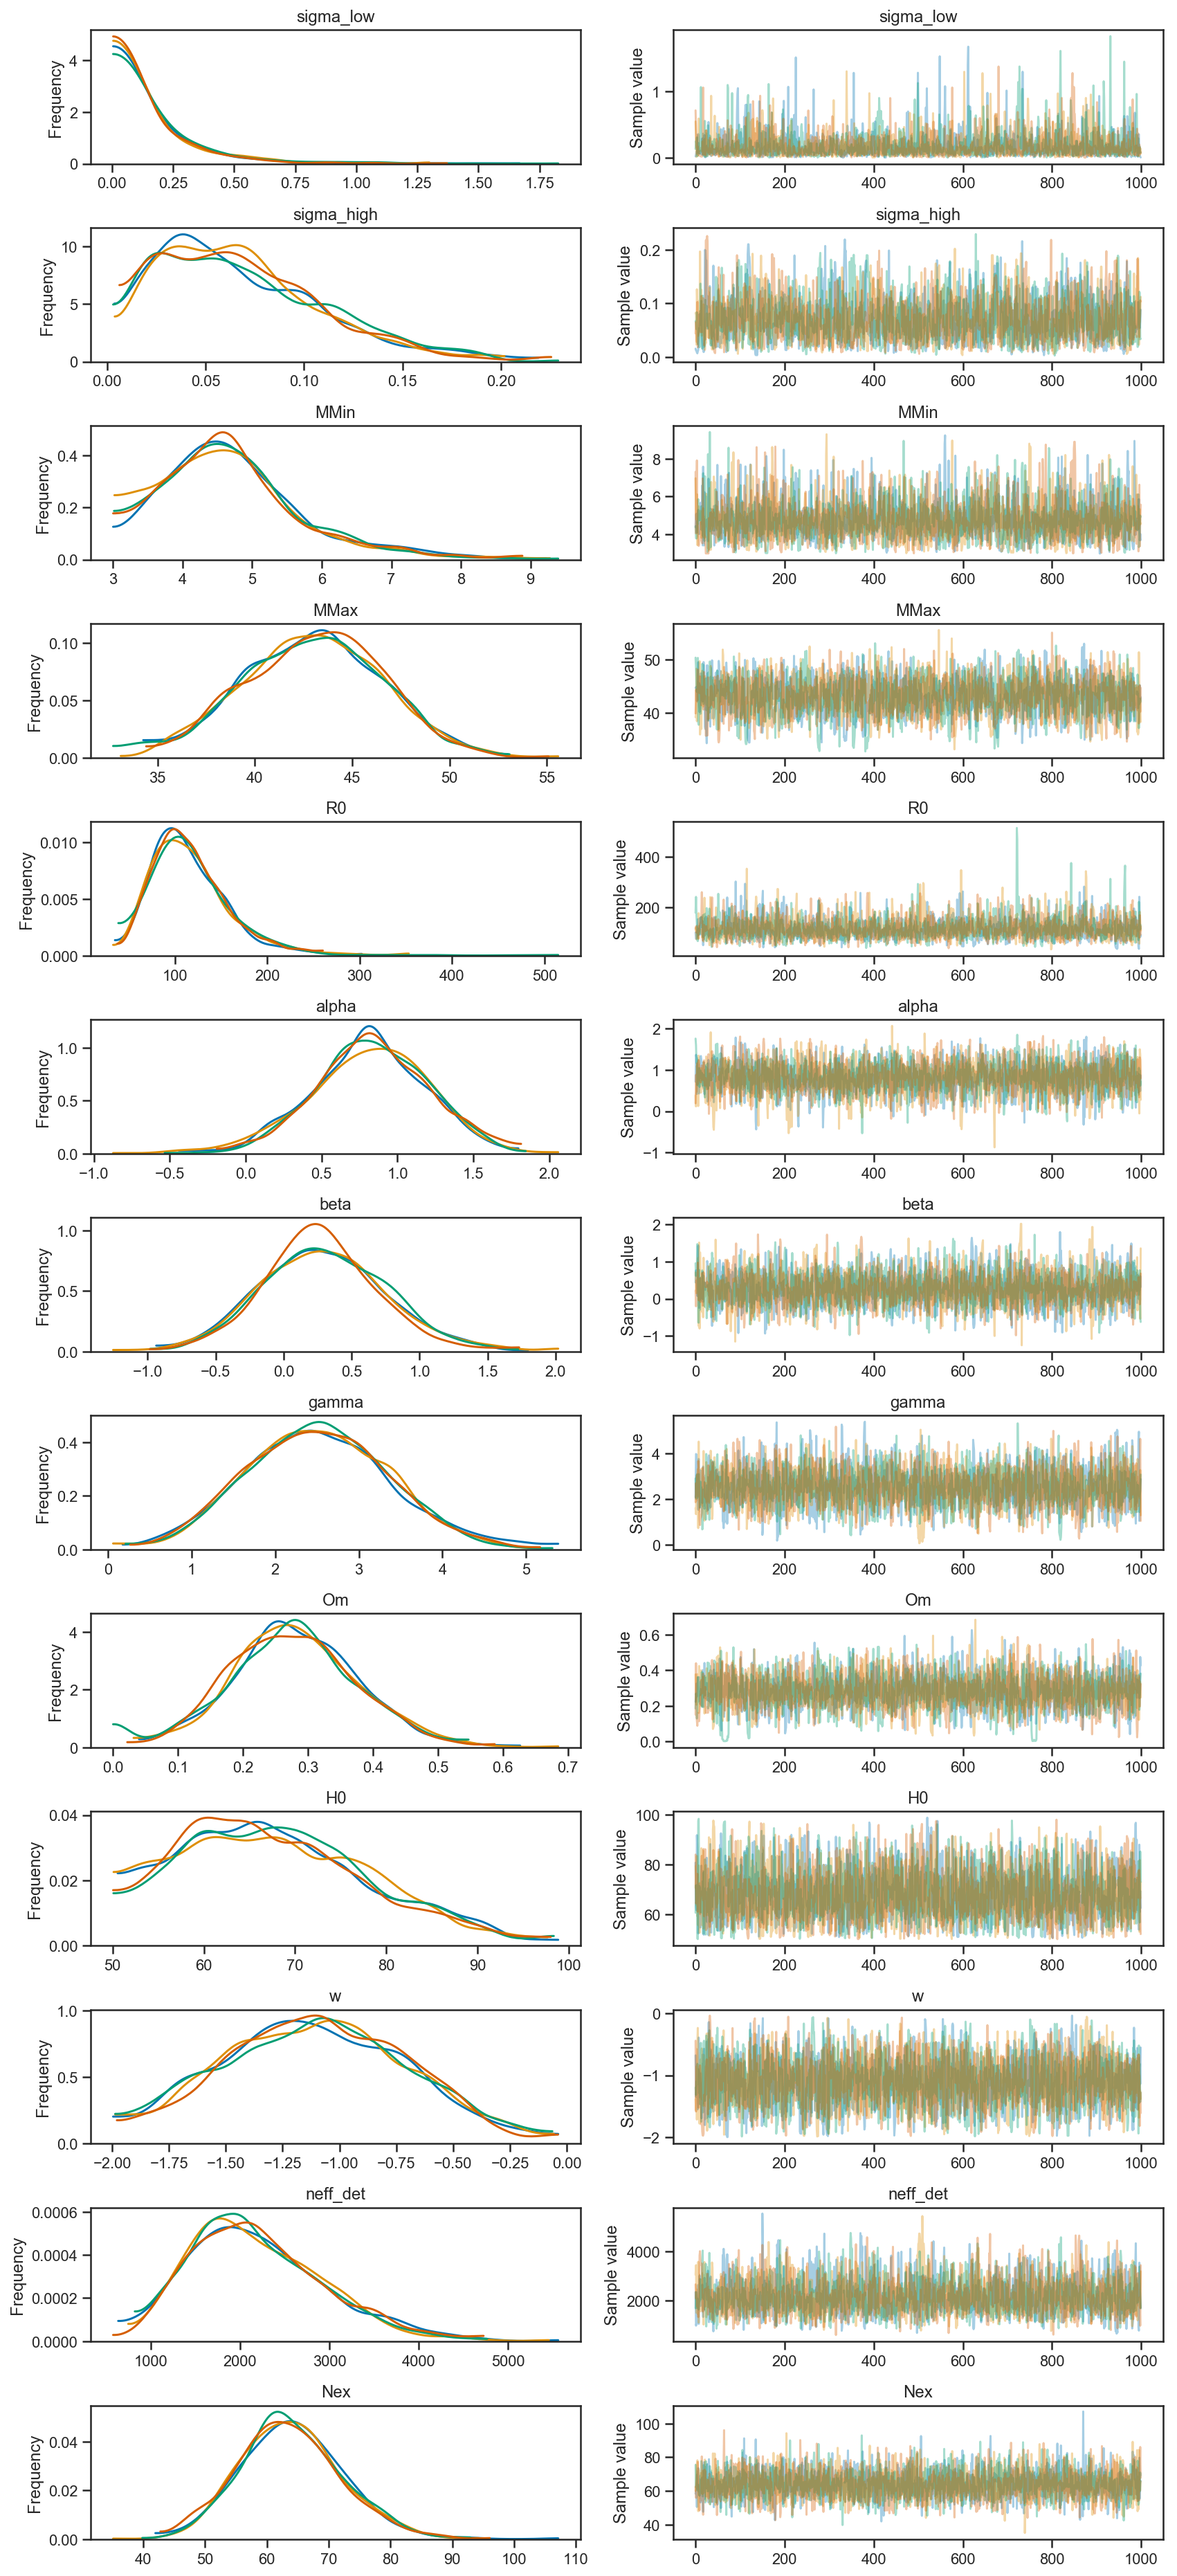

In [30]:
pm.traceplot(t)